In [1]:
!pip install hroch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.2 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, cohen_kappa_score
from HROCH import PHCRegressor
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.pyplot import figure


def qwk(y_true, y_pred, **kwargs):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic', **kwargs)

In [3]:
INPUT_DIR = Path('/kaggle/input/playground-series-s3e5/')

train_data = pd.read_csv(f'{INPUT_DIR}/train.csv')
train_data['data_type'] = 0

test_data = pd.read_csv(f'{INPUT_DIR}/test.csv')
test_data['data_type'] = 0

additional = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')
additional['data_type'] = 1

submission = pd.read_csv(INPUT_DIR / 'sample_submission.csv')

train_data = pd.concat([train_data, additional]).reset_index(drop=True)

# drop duplicates - 
train_data = train_data.loc[
    ~(train_data
        .drop(columns=['Id', 'data_type'])
        .duplicated(keep = "first"))].reset_index(drop=True)

features = list(train_data.columns)
features.remove('Id')
features.remove('quality')

#save original
train_data_orig = train_data.copy()
train_X_orig = train_data[features].copy()
train_y_orig = train_data.quality.copy()
test_X = test_data.drop(labels='Id', axis=1).copy()

In [4]:
def fit(train_data, RND=42):

    SAMPLES=500

    frames = [train_data[train_data['quality'] == 8].sample(n=SAMPLES, random_state=RND, replace=True),
              train_data[train_data['quality'] == 7].sample(n=SAMPLES, random_state=RND, replace=True),
              train_data[train_data['quality'] == 6].sample(n=SAMPLES, random_state=RND, replace=True),
              train_data[train_data['quality'] == 5].sample(n=SAMPLES, random_state=RND, replace=True),
              train_data[train_data['quality'] == 4].sample(n=SAMPLES, random_state=RND, replace=True),
              train_data[train_data['quality'] == 3].sample(n=SAMPLES//4, random_state=RND, replace=True)]

    train_data = pd.concat(frames)

    train_X = train_data[features].copy()
    train_y = train_data.quality.copy()

    best_score = {'kappa':0.0, 'r2': 0.0, 'kappa_orig':0.0, 'eq':''}
    prob={'add':1.0,'mul':1.0, 'gt':1.0, 'lt':1.0,'nop':1.0}
    fprobs=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0]

    preds = None
    ITER = 100
    STEP = 50000
    df_progress = pd.DataFrame(columns=['iter', 'kappa', 'r2', 'kappa_orig'])

    best_reg = None
    reg = PHCRegressor(
        num_threads=2, iter_limit=STEP, 
        code_size=32, const_size=32,  
        problem=prob,feature_probs=fprobs, 
        random_state=RND, save_model=True)

    for j in range(1, ITER+1):
        reg.fit(train_X, train_y);

        pred_y = reg.predict(train_X)
        pred_y = np.rint(pred_y).astype(int)
        r2 = r2_score(train_y, pred_y)
        kappa = qwk(train_y, pred_y)

        pred_y_orig = reg.predict(train_X_orig)
        pred_y_orig = np.rint(pred_y_orig).astype(int)
        kappa_orig = qwk(train_y_orig, pred_y_orig)

        df_progress = df_progress.append({'iter':j,'kappa':kappa, 'r2':r2, 'kappa_orig':kappa_orig}, ignore_index = True)

        if kappa_orig > best_score['kappa_orig']:
            #print(f'{j}: {kappa} {r2} {kappa_orig}                  ')
            #print(reg.sexpr)
            best_score = {'kappa':kappa, 'r2':r2, 'kappa_orig':kappa_orig, 'eq':reg.sexpr}
            best_reg = reg
            # save predictions
            #preds = reg.predict(test_X)
    
    return best_reg


In [5]:
from sklearn.model_selection import StratifiedKFold

base_features = [
        'fixed acidity', 'volatile acidity', 'citric acid',
        'residual sugar', 'chlorides', 'free sulfur dioxide',
        'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
        'data_type']

N_REPEATS = 5
N_FOLDS = 10

oof_preds = np.zeros((len(train_data), N_REPEATS))
test_preds = np.zeros((len(test_data), N_REPEATS))
for i in range(N_REPEATS):
    k_fold = StratifiedKFold(n_splits=N_FOLDS, random_state=43 + i, shuffle=True)
    for train_index, test_index in k_fold.split(train_data, train_data['quality']):
        X_train, X_valid = train_data.loc[train_index], train_data.loc[test_index]
        reg = fit(X_train, 43 + i)
        print(reg.sexpr)
        
        oof_pred = np.rint(reg.predict(X_valid.filter(features))).astype(int)
        test_pred = np.rint(reg.predict(test_data.filter(features))).astype(int)
        
        oof_preds[test_index, i] = np.clip(oof_pred, 3, 8)
        test_preds[:, i] = np.clip(test_pred, 3, 8)
    
    oof_qwk = np.round(qwk(train_data['quality'], oof_preds[:, i]), 4)
    print(f'rep: {i} qwk: {oof_qwk}')

# overall:    
oof_preds = sp.stats.mode(oof_preds, axis=1)[0].ravel()    
test_preds = sp.stats.mode(test_preds, axis=1)[0].ravel()

((0.48917484283447265625)*(x11+((((x10)>(0.74154365062713623047))>x10)+(((0.59965765476226806641)<(x10))+((0.63636636734008789062)<(x10))))))

((x11*(0.47802433371543884277))+(((x10>(0.63664746284484863281))+((0.50143474340438842773)+(x10>x10)))*(((0.13879549503326416016)+x2)<((0.02745695039629936218)<(((x11+x11)*(0.02268747799098491669))>(0.43784070014953613281))))))

((((0.69066327810287475586)<x10)+((x11*x2)*((-0.08053582906723022461)*((0.81951808929443359375)+x12))))+((((0.56371110677719116211))*((x11*x2)>x5))*x11))

((x2*((-0.12687645852565765381)*(x12*(x2*x11))))+((((x8>x10)*x10)>(0.63203454017639160156))+((0.52273660898208618164)*x11)))

((x11+((((0.68755888938903808594)<x10)+((((0.65941625833511352539)>(x12*x2))*((-2.26807260513305664062)*(x12*x2)))<((0.68755888938903808594)<x10)))+((-2.26807260513305664062)*(x12*x2))))*(0.52638590335845947266))

((0.48985239863395690918)*(((((0.68447583913803100586)<x10)>(x10+((0.00665398361161351204)*x11)))+(((0.68447583913803100586)<x10)>(x1

Quadratic Weighted Kappa = 0.5316


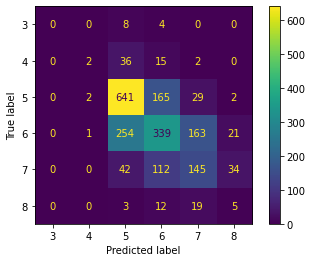

In [6]:
oof_data = train_data.assign(oof = oof_preds).query('data_type == 0')
oof_qwk = np.round(qwk(oof_data['quality'], oof_data['oof']), 4)

from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
print(f'Quadratic Weighted Kappa = {oof_qwk}')
cm = confusion_matrix(oof_data['quality'], oof_data['oof'])
ConfusionMatrixDisplay(cm, display_labels=range(3, 9)).plot()

In [7]:
submission = pd.DataFrame(data={'Id': test_data.Id, 'quality': test_preds.astype('int')})
submission.to_csv('submission.csv', index=False)
submission.describe()

,Id,quality
count,1372.000000,1372.000000
mean,2741.500000,5.812682
std,396.206596,0.863752
min,2056.000000,5.000000
25%,2398.750000,5.000000
50%,2741.500000,6.000000
75%,3084.250000,6.000000
max,3427.000000,8.000000


In [8]:
submission['quality'].value_counts()

5    610
6    463
7    245
8     54
Name: quality, dtype: int64

In [9]:
!ls

__notebook__.ipynb  submission.csv
